In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
!pwd

/home/as111/sipm-analysis


In [3]:
# data folder
path = "/scratch/gpfs/as111/results/2022-11-22/"
data = {}
positions = ['top', 'bottom']
channels = [0, 1, 2, 3]
voltages = [63, 65, 67, 69, 71]
for pos in positions:
    data[pos] = {}
    for ch in channels:
        data[pos][ch] = {}
        for volt in voltages:
            data[pos][ch][volt] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
            files = glob.glob(f"{path}/*volt_{volt}_pos_{pos}*_wf.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data[pos][ch][volt]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
                if data[pos][ch][volt]['time'].shape[0]==0:
                    data[pos][ch][volt]['time'] = np.array(df['time'])
                if data[pos][ch][volt]['avg_spe_wf'].shape[0]==0:
                    data[pos][ch][volt]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
                else:
                    data[pos][ch][volt]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            df = None
            data[pos][ch][volt]['avg_spe_wf'] /= data[pos][ch][volt]['n_spe_wfs']
print('keys: ', list(data['top'][0][63].keys()))

keys:  ['n_spe_wfs', 'avg_spe_wf', 'time']


top ch0 63V 63604 waveforms selected
top ch0 65V 57580 waveforms selected
top ch0 67V 51528 waveforms selected
top ch0 69V 47122 waveforms selected
top ch0 71V 42582 waveforms selected
top ch1 63V 44717 waveforms selected
top ch1 65V 38749 waveforms selected
top ch1 67V 33119 waveforms selected
top ch1 69V 29974 waveforms selected
top ch1 71V 25953 waveforms selected
top ch2 63V 48227 waveforms selected
top ch2 65V 41733 waveforms selected
top ch2 67V 36132 waveforms selected
top ch2 69V 32584 waveforms selected
top ch2 71V 28589 waveforms selected
top ch3 63V 63201 waveforms selected
top ch3 65V 57378 waveforms selected
top ch3 67V 51817 waveforms selected
top ch3 69V 46732 waveforms selected
top ch3 71V 42262 waveforms selected
bottom ch0 63V 51767 waveforms selected
bottom ch0 65V 45033 waveforms selected
bottom ch0 67V 39703 waveforms selected
bottom ch0 69V 35163 waveforms selected
bottom ch0 71V 31184 waveforms selected
bottom ch1 63V 54996 waveforms selected
bottom ch1 65V 48947

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

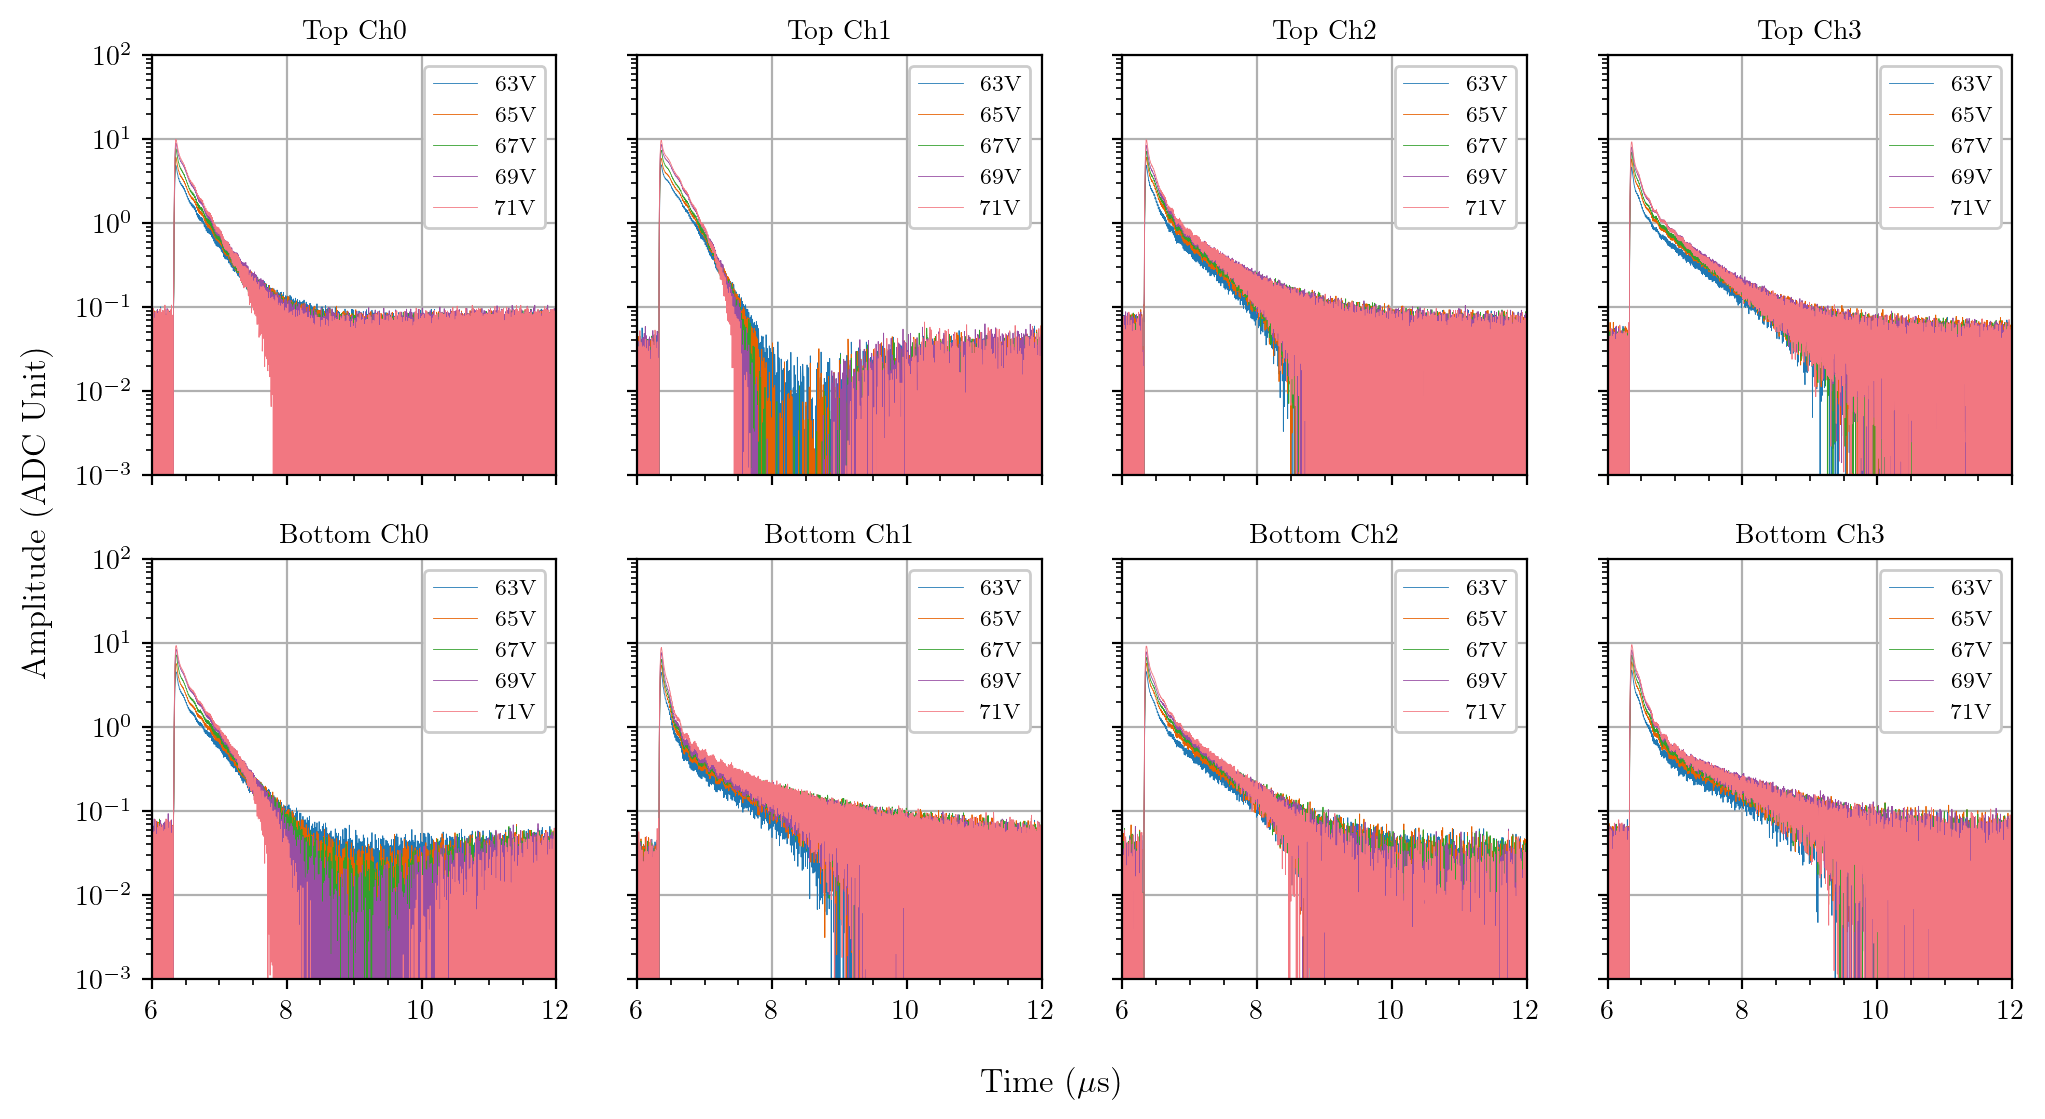

In [4]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            print(f'{pos} ch{ch} {volt}V {data[pos][ch][volt]["n_spe_wfs"]:.0f} waveforms selected')
            axs[i, j].plot(
                data[pos][ch][volt]['time'],
                data[pos][ch][volt]['avg_spe_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## FFT

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

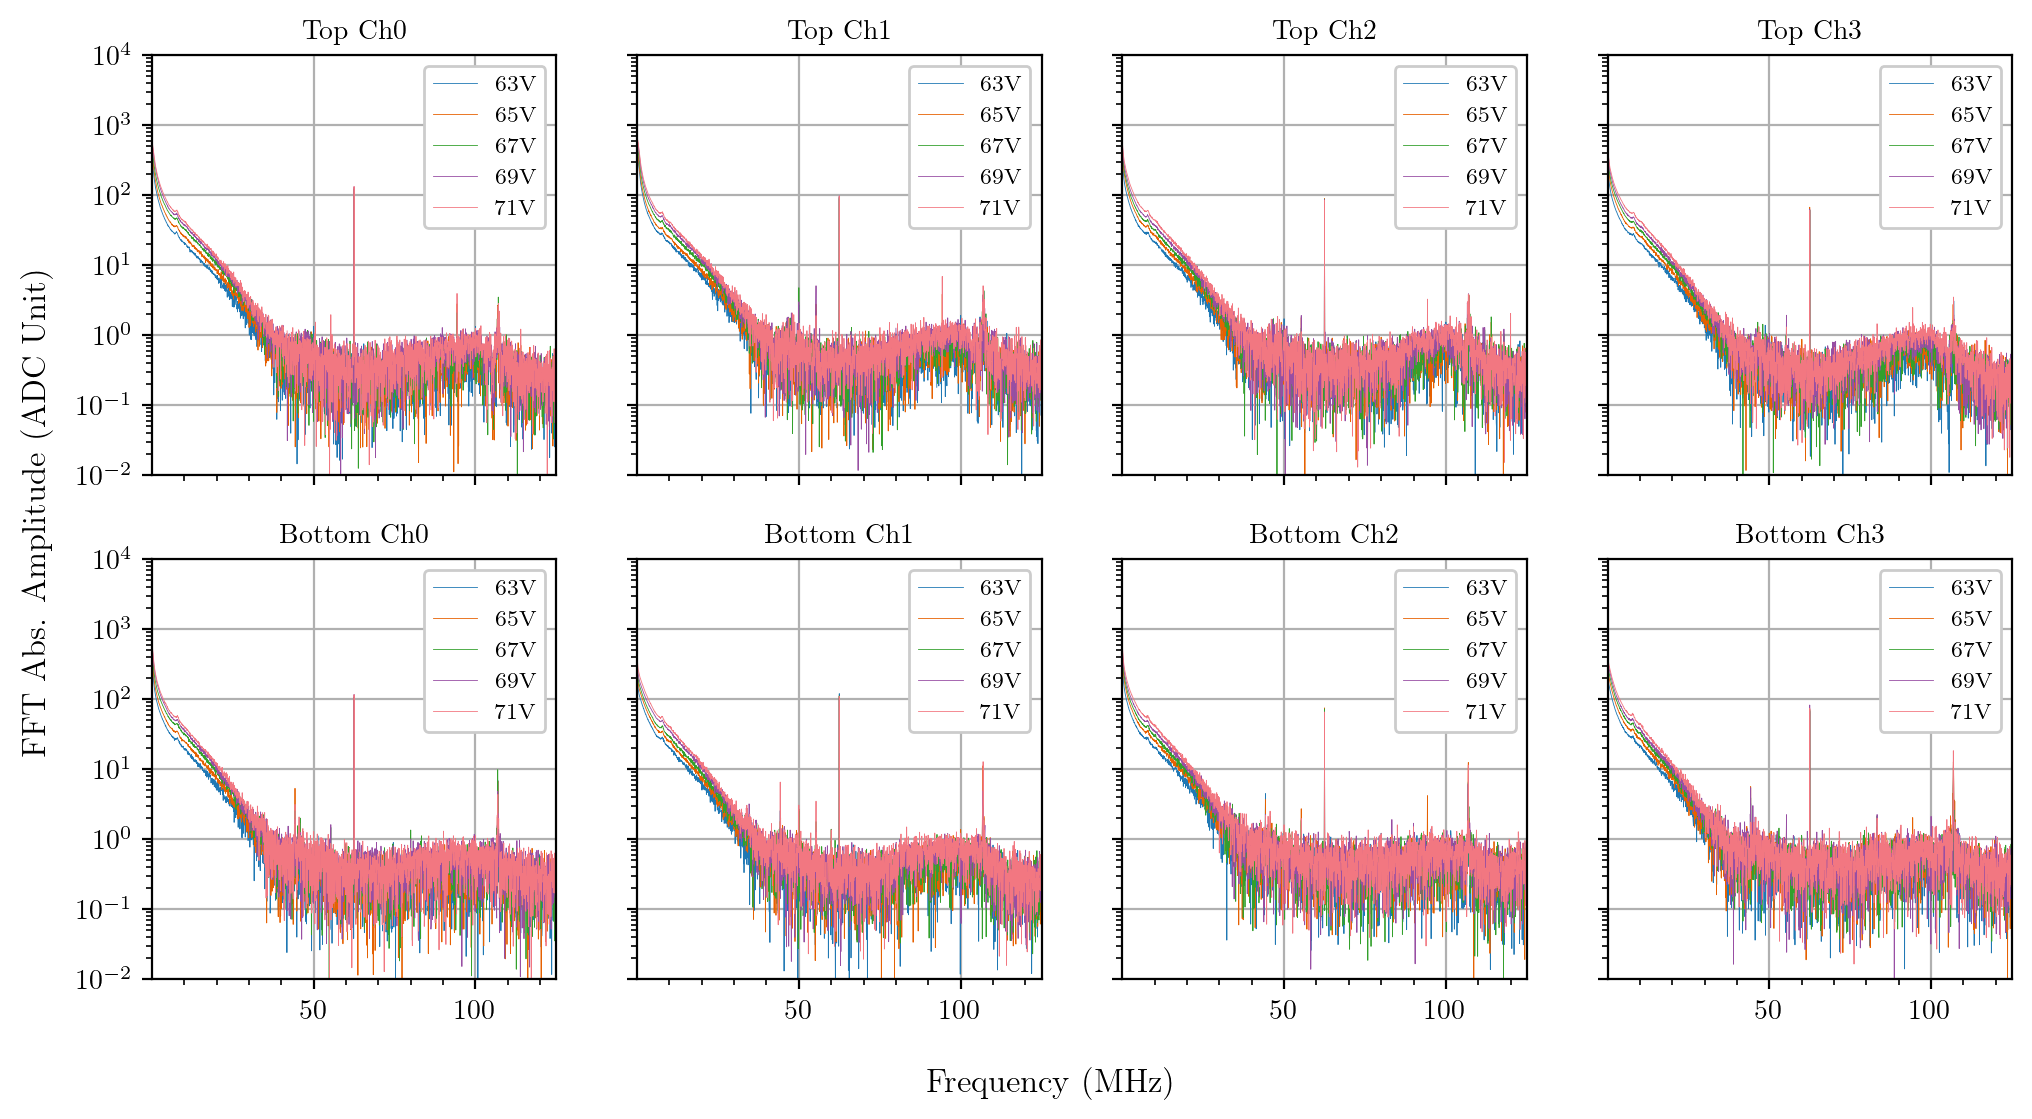

In [5]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            data[pos][ch][volt]['fft_spe_wf'] = fft(data[pos][ch][volt]['avg_spe_wf'])
            dt = data[pos][ch][volt]['time'][1]-data[pos][ch][volt]['time'][0]
            t_total = dt+data[pos][ch][volt]['time'][-1]
            n_over_2 = int(data[pos][ch][volt]['time'].shape[0]/2)
            data[pos][ch][volt]['frequency'] = data[pos][ch][volt]['time']/dt/t_total
            axs[i, j].plot(
                data[pos][ch][volt]['frequency'][:n_over_2],
                abs(data[pos][ch][volt]['fft_spe_wf'][:n_over_2]),
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(data[pos][ch][volt]['frequency'][1], data[pos][ch][volt]['frequency'][n_over_2])
        axs[i, j].set_ylim(1e-2, 1e4)
        # axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

# Fit: exponential pulses with time jitter
Scintillation pulse (one component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$
We include two scintillation pulse components with distinct $\tau$.

In [6]:
def template(t, a_1, tau_1, a_2, tau_2, sigma, t0):
        return func.pulse_jitter(t, a_1, tau_1, sigma, t0) + func.pulse_jitter(t, a_2, tau_2, sigma, t0)

In [7]:
# Fit SPE average waveform
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            pretrg = 5 #us
            err = np.std(data[pos][ch][volt]['avg_spe_wf'][data[pos][ch][volt]['time']<pretrg])
            fit_range = [6.2,10] #us
            range_arr = (data[pos][ch][volt]['time']<fit_range[1])&(data[pos][ch][volt]['time']>fit_range[0])
            popt,pcov = curve_fit(
                template,
                data[pos][ch][volt]['time'][range_arr], 
                data[pos][ch][volt]['avg_spe_wf'][range_arr], 
                p0=[7, 0.05, 6, 0.7, 0.008, 6.34], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
            data[pos][ch][volt]['pars'] = popt
            data[pos][ch][volt]['cov'] = pcov

/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: invalid value encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

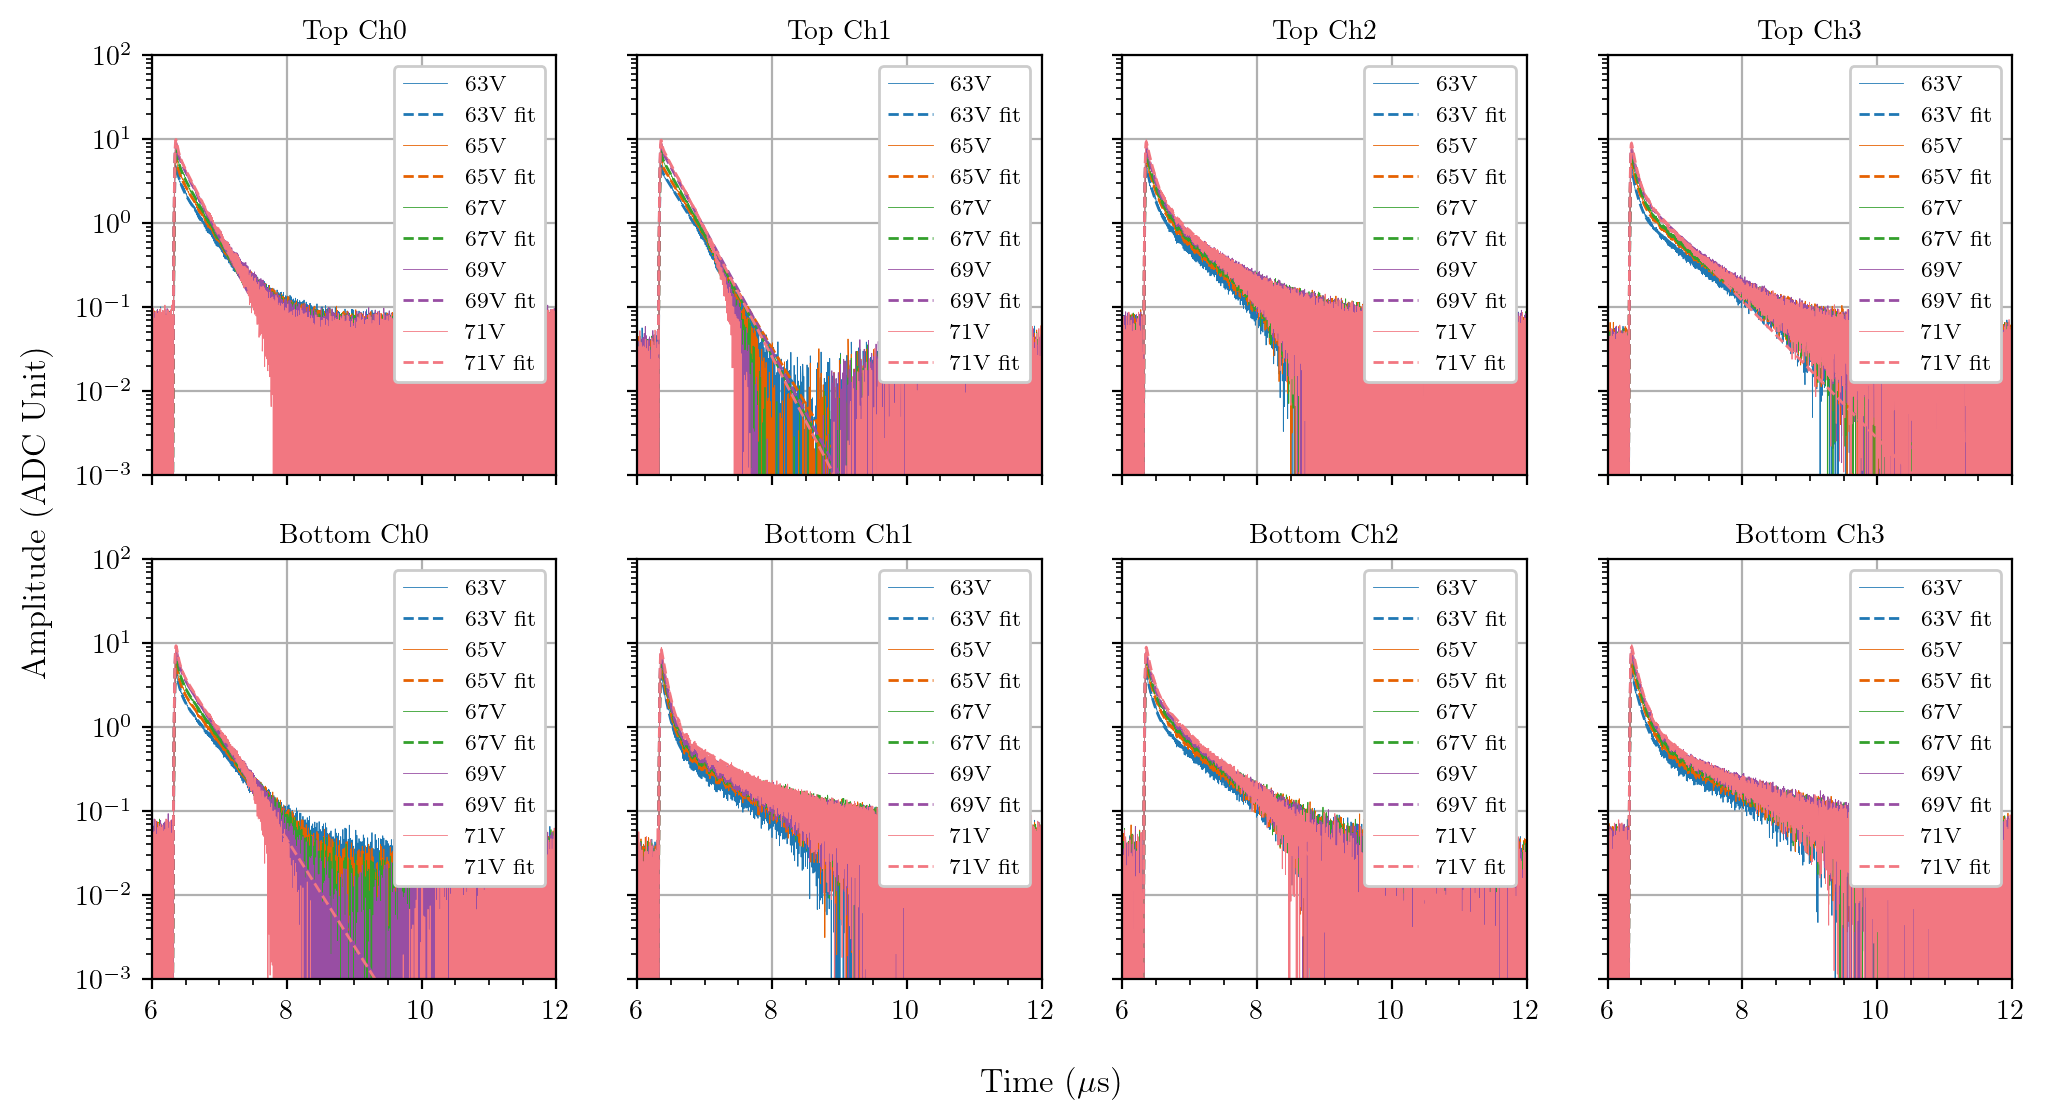

In [8]:
# Make plots for all datasets
# Fitted SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].plot(
                data[pos][ch][volt]['time'],
                data[pos][ch][volt]['avg_spe_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
            axs[i, j].plot(
                data[pos][ch][volt]['time'],
                template(data[pos][ch][volt]['time'], *data[pos][ch][volt]['pars']),
                label=f'{volt}V fit', color=f'C{k}', linestyle='--', linewidth=1)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [9]:
# Fit result container
# Initialize
spe_fit = {}
for pos in positions:
    spe_fit[pos] = {}
    for ch in channels:
        spe_fit[pos][ch] = {}

In [10]:
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
            spe_fit[pos][ch]['volts'] = np.array(voltages)
            spe_fit[pos][ch]['a1'] = np.array([data[pos][ch][volt]['pars'][0] for volt in voltages])
            spe_fit[pos][ch]['tau1'] = np.array([data[pos][ch][volt]['pars'][1] for volt in voltages])
            spe_fit[pos][ch]['a2'] = np.array([data[pos][ch][volt]['pars'][2] for volt in voltages])
            spe_fit[pos][ch]['tau2'] = np.array([data[pos][ch][volt]['pars'][3] for volt in voltages])
            spe_fit[pos][ch]['a1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data[pos][ch][volt]['cov'][0, 0]) for volt in voltages])
            spe_fit[pos][ch]['tau1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data[pos][ch][volt]['cov'][1, 1]) for volt in voltages])
            spe_fit[pos][ch]['a2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data[pos][ch][volt]['cov'][2, 2]) for volt in voltages])
            spe_fit[pos][ch]['tau2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data[pos][ch][volt]['cov'][3, 3]) for volt in voltages])

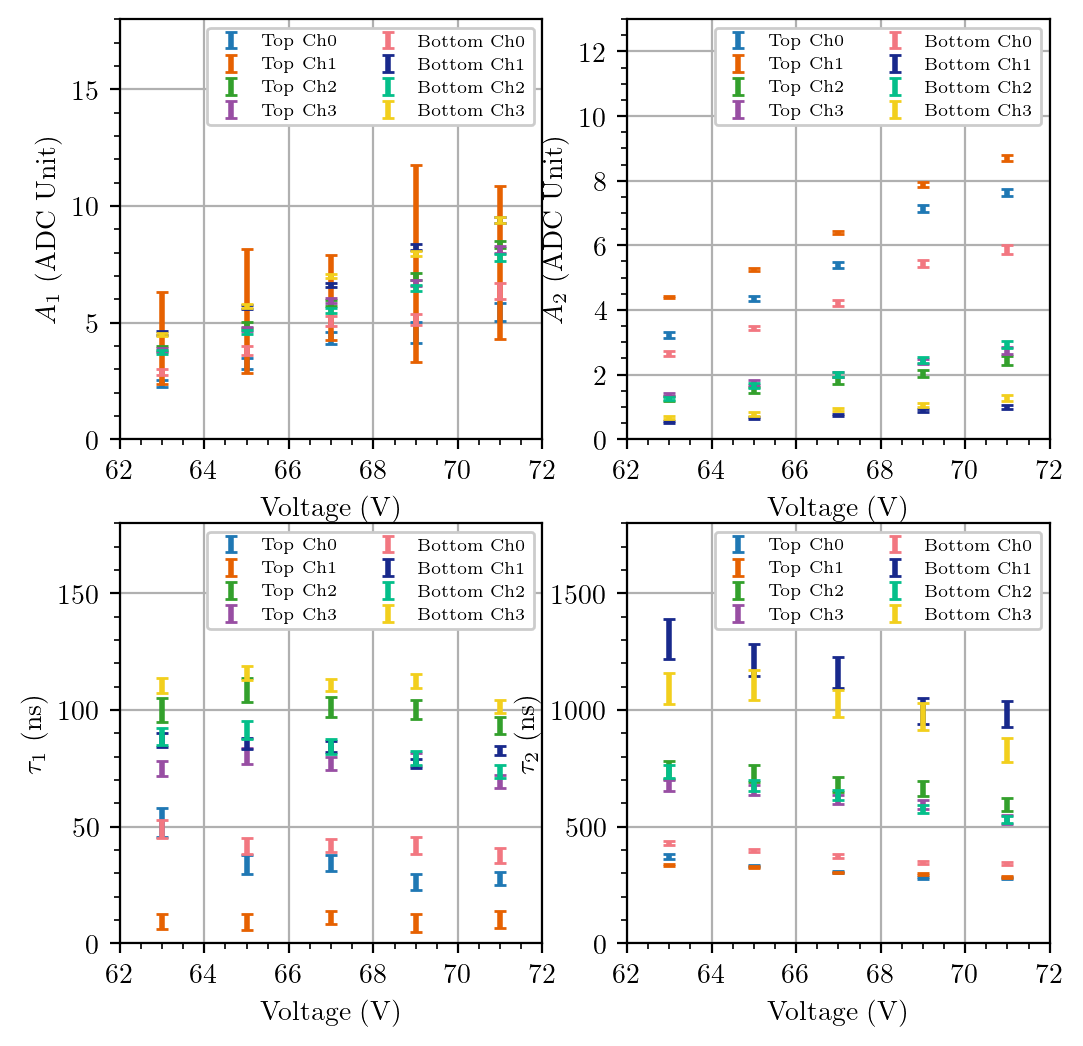

In [11]:
# Make plots for all parameters
# SPE average waveform
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_size_inches(6, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        axs[0, 0].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['a1'],
            yerr=spe_fit[pos][ch]['a1err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[0, 0].set_ylabel(r'$A_1$ (ADC Unit)')
        axs[0, 0].set_ylim(0,18)
        axs[0, 1].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['a2'],
            yerr=spe_fit[pos][ch]['a2err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[0, 1].set_ylabel(r'$A_2$ (ADC Unit)')
        axs[0, 1].set_ylim(0,13)
        axs[1, 0].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['tau1']*1e3,
            yerr=spe_fit[pos][ch]['tau1err']*1e3,
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[1, 0].set_ylabel(r'$\tau_1$ (ns)')
        axs[1, 0].set_ylim(0,180)
        axs[1, 1].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['tau2']*1e3,
            yerr=spe_fit[pos][ch]['tau2err']*1e3,
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[1, 1].set_ylabel(r'$\tau_2$ (ns)')
        axs[1, 1].set_ylim(0,1800)

for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel('Voltage (V)')
        axs[i, j].legend(loc='upper right',ncol=2,fontsize=6)
        axs[i, j].minorticks_on()
        axs[i, j].grid()

# 11/20 Triplet lifetime
Here the average waveforms are deconvolved channel-by-channel using their respective SPE pulse shapes.
The deconvolved waveform is given by
$$f_{deconv}(t) = \mathcal{F}^{-1}\left(\frac{\mathcal{F}(f_{original}(t))}{\mathcal{F}(f_{SiPM}(t))}\right)$$
Note that the SiPM pulse shape has to be shifted such that the trigger for it is at $t=0$.<br>

The average waveforms are selected from the events with $0.1<F_{\rm prompt}<0.5$ and $20<N_{\rm PE}<200$ ($100<N_{\rm PE}<1000$) for the top (bottom), corresponding to an energy range of $100$ keV $\lesssim E \lesssim 1000$ keV

In [12]:
# data folder
path_scint = "/scratch/gpfs/as111/results/2022-11-20/"
data_scint = {}
positions = ['top', 'bottom']
channels = [0, 1, 2, 3]
voltages = [63, 65, 67, 69, 71]
for pos in positions:
    data_scint[pos] = {}
    for ch in channels:
        data_scint[pos][ch] = {}
        for volt in voltages:
            data_scint[pos][ch][volt] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
            files = glob.glob(f"{path_scint}/*volt_{volt}_pos_{pos}*_wf.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data_scint[pos][ch][volt]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
                if data_scint[pos][ch][volt]['time'].shape[0]==0:
                    data_scint[pos][ch][volt]['time'] = np.array(df['time'])
                if data_scint[pos][ch][volt]['avg_scint_wf'].shape[0]==0:
                    data_scint[pos][ch][volt]['avg_scint_wf'] = np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
                else:
                    data_scint[pos][ch][volt]['avg_scint_wf'] += np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
            df = None
            data_scint[pos][ch][volt]['avg_scint_wf'] /= data_scint[pos][ch][volt]['n_scint_wfs']
print('keys: ', list(data_scint['top'][0][63].keys()))

keys:  ['n_scint_wfs', 'avg_scint_wf', 'time']


top ch0 63V 235433 waveforms selected
top ch0 65V 223150 waveforms selected
top ch0 67V 175010 waveforms selected
top ch0 69V 152415 waveforms selected
top ch0 71V 144322 waveforms selected
top ch1 63V 235433 waveforms selected
top ch1 65V 223150 waveforms selected
top ch1 67V 175010 waveforms selected
top ch1 69V 152415 waveforms selected
top ch1 71V 144322 waveforms selected
top ch2 63V 235433 waveforms selected
top ch2 65V 223150 waveforms selected
top ch2 67V 175010 waveforms selected
top ch2 69V 152415 waveforms selected
top ch2 71V 144322 waveforms selected
top ch3 63V 235433 waveforms selected
top ch3 65V 223150 waveforms selected
top ch3 67V 175010 waveforms selected
top ch3 69V 152415 waveforms selected
top ch3 71V 144322 waveforms selected
bottom ch0 63V 215869 waveforms selected
bottom ch0 65V 139791 waveforms selected
bottom ch0 67V 81002 waveforms selected
bottom ch0 69V 55261 waveforms selected
bottom ch0 71V 47957 waveforms selected
bottom ch1 63V 215869 waveforms select

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

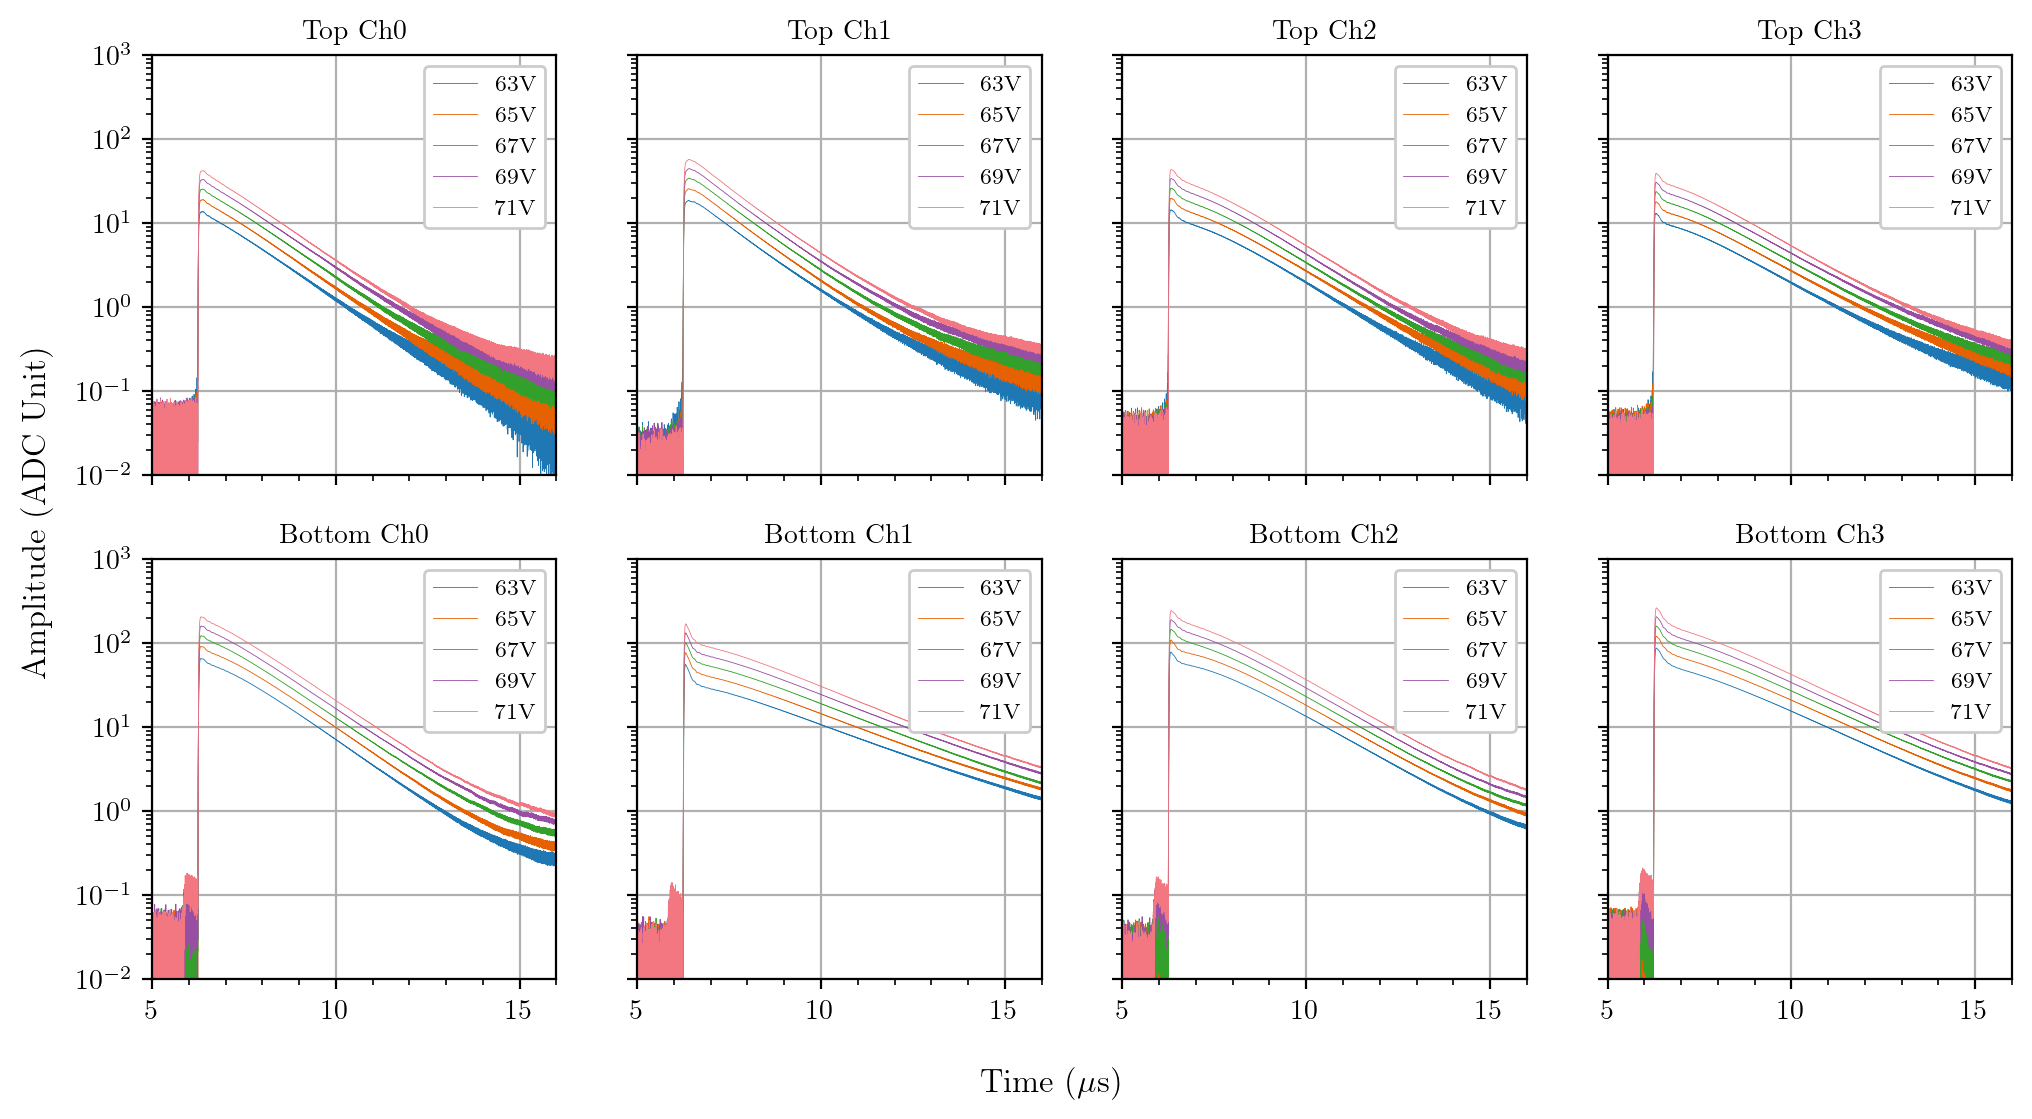

In [13]:
# Make plots for all datasets
# Average LAr scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            print(f'{pos} ch{ch} {volt}V {data_scint[pos][ch][volt]["n_scint_wfs"]:.0f} waveforms selected')
            axs[i, j].plot(
                data_scint[pos][ch][volt]['time'],
                data_scint[pos][ch][volt]['avg_scint_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(5, 16)
        axs[i, j].set_ylim(1e-2, 1e3)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Deconvolution

In [14]:
# Deconvolution channel by channel
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*data[pos][ch][volt]['pars'][5])) for freq in data[pos][ch][volt]['frequency']])
            data_scint[pos][ch][volt]['deconv'] = ifft(fft(data_scint[pos][ch][volt]['avg_scint_wf'])/data[pos][ch][volt]['fft_spe_wf']*shift).real

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

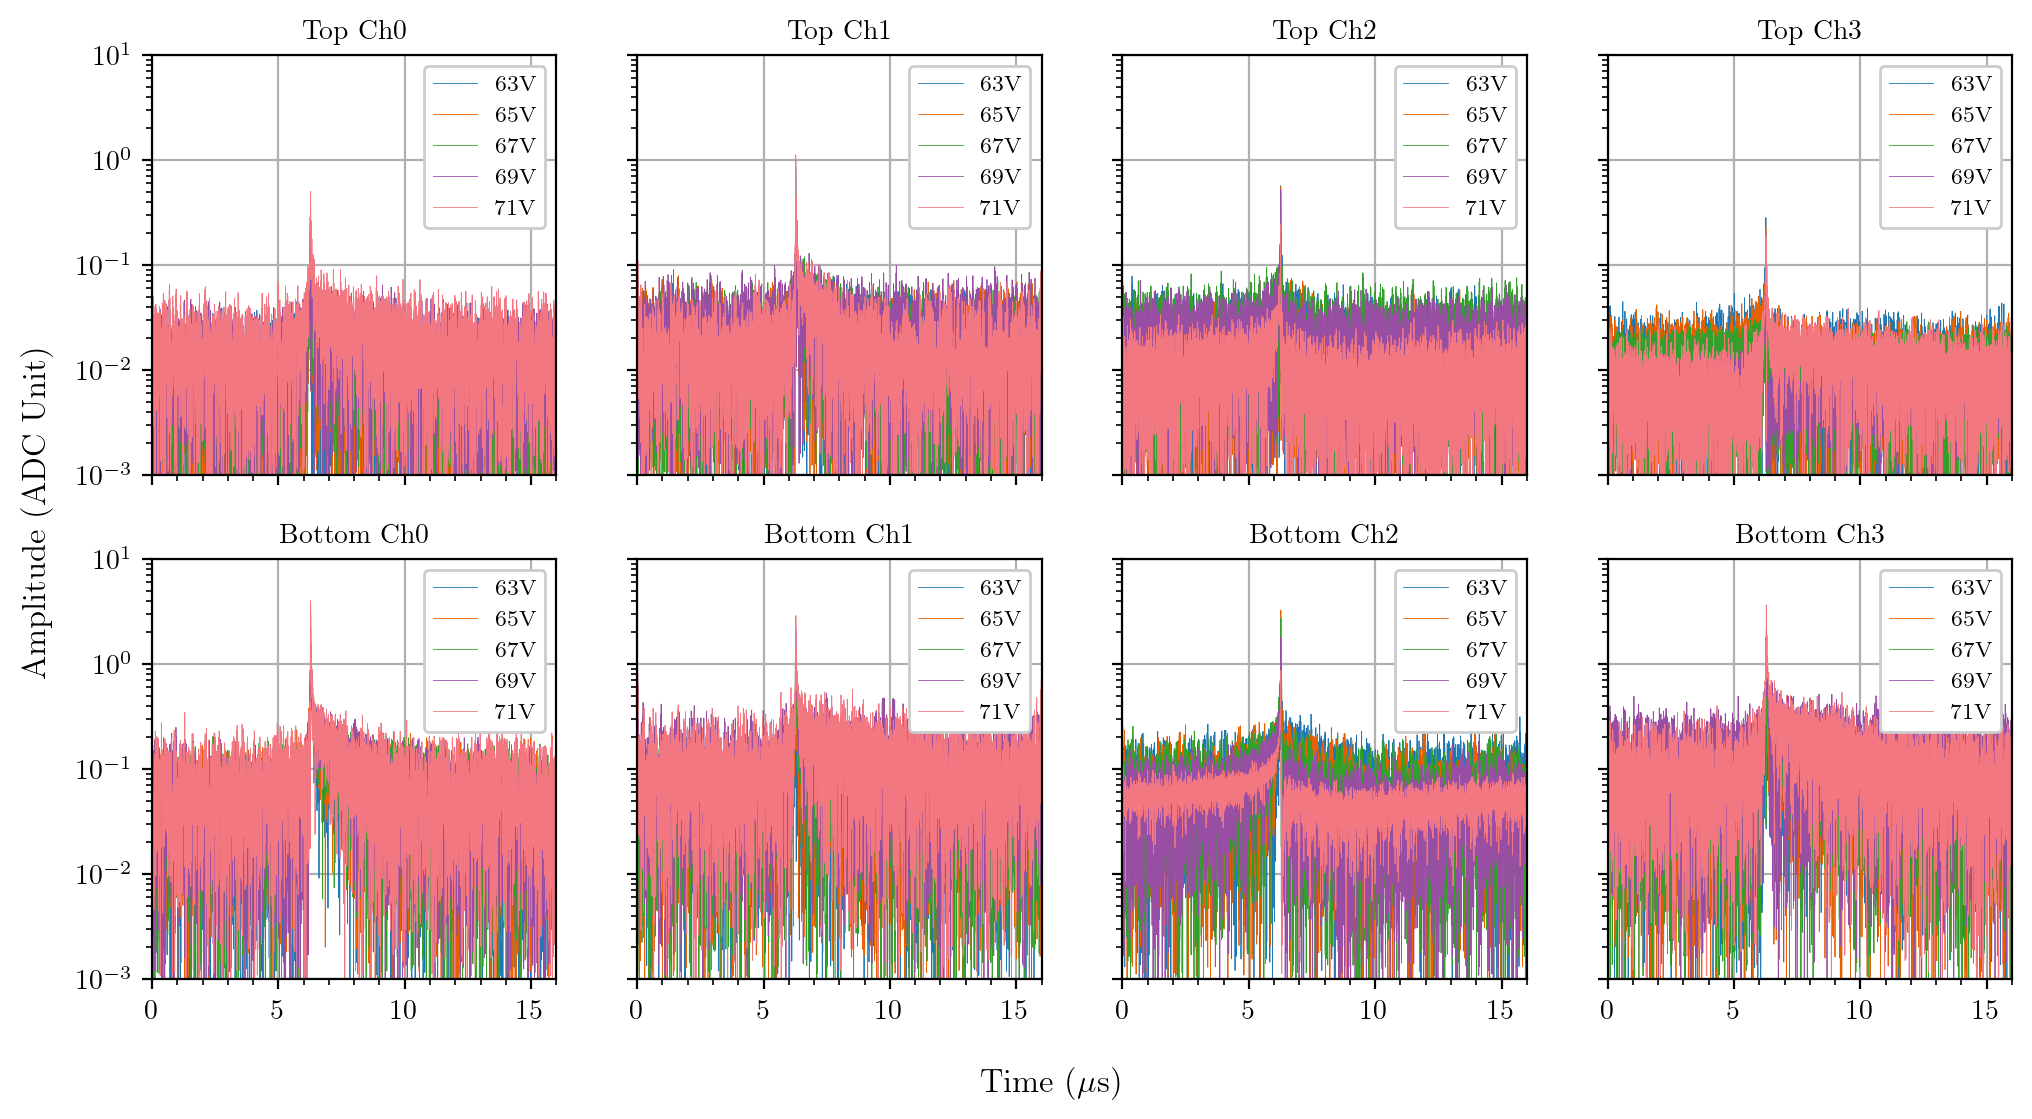

In [15]:
# Make plots for all datasets
# Deconvolved scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].plot(
                data_scint[pos][ch][volt]['time'],
                abs(data_scint[pos][ch][volt]['deconv']),
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(0, 16)
        axs[i, j].set_ylim(1e-3, 1e1)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Summation

In [16]:
for pos in positions:
    data_scint[pos][-1] = {}
    for volt in voltages:
        data_scint[pos][-1][volt] = {'time': data_scint[pos][0][volt]['time'], 'sum_wf': np.zeros(data_scint[pos][0][volt]['time'].shape[0])}
        for ch in channels:
            data_scint[pos][-1][volt]['sum_wf'] += data_scint[pos][ch][volt]['deconv']

Text(0.02, 0.5, 'Amplitude (ADC Unit)')

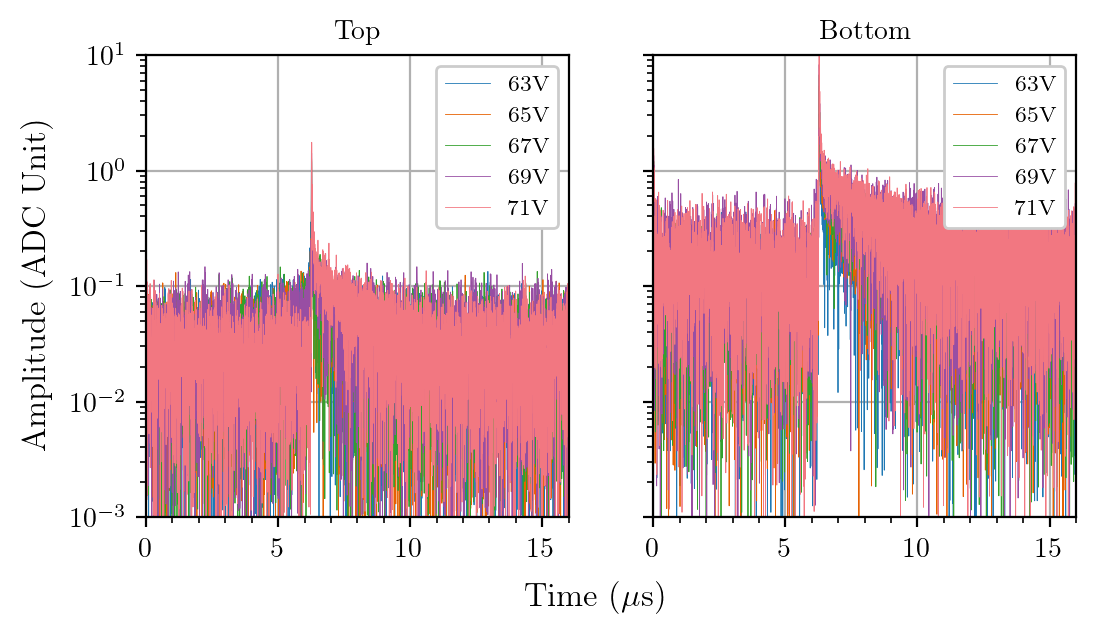

In [17]:
# Make plots for all datasets
# Summed scintillation waveform
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 3)
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        axs[i].plot(
                    data_scint[pos][-1][volt]['time'],
                    abs(data_scint[pos][-1][volt]['sum_wf']),
                    label=f'{volt}V', color=f'C{j}', linewidth=0.3)
        axs[i].legend(loc='upper right')
        axs[i].set_xlim(0, 16)
        axs[i].set_ylim(1e-3, 1e1)
        axs[i].set_yscale('log')
        axs[i].minorticks_on()
        axs[i].grid()
        axs[i].set_title(f'{pos[0].upper()}{pos[1:]}')
fig.supxlabel(r'Time ($\mu$s)', y=-0.05)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.02)

ch0 A_S=1.04+/-0.07  TAU_S=0.0120+/-0.0010us  A_T=0.06+/-0.00  TAU_T=1.117+/-0.089us sigma=0.0034+/-0.0004us t0=6.275+/-0.000us
ch1 A_S=1.16+/-0.05  TAU_S=0.0151+/-0.0008us  A_T=0.08+/-0.00  TAU_T=1.226+/-0.074us sigma=0.0034+/-0.0003us t0=6.275+/-0.000us
ch2 A_S=1.14+/-0.07  TAU_S=0.0121+/-0.0009us  A_T=0.07+/-0.00  TAU_T=1.143+/-0.085us sigma=0.0034+/-0.0003us t0=6.275+/-0.000us
ch3 A_S=6.58+/-7.24  TAU_S=0.0016+/-0.0017us  A_T=0.08+/-0.00  TAU_T=0.961+/-0.079us sigma=0.0051+/-0.0005us t0=6.284+/-0.002us
ch0 A_S=2.85+/-0.10  TAU_S=0.0201+/-0.0009us  A_T=0.21+/-0.01  TAU_T=1.490+/-0.083us sigma=0.0033+/-0.0003us t0=6.286+/-0.000us
ch1 A_S=2.82+/-0.16  TAU_S=0.0180+/-0.0014us  A_T=0.21+/-0.01  TAU_T=1.332+/-0.102us sigma=0.0039+/-0.0004us t0=6.286+/-0.000us
ch2 A_S=3.99+/-0.14  TAU_S=0.0170+/-0.0008us  A_T=0.25+/-0.01  TAU_T=1.509+/-0.078us sigma=0.0037+/-0.0003us t0=6.279+/-0.000us
ch3 A_S=3.69+/-0.13  TAU_S=0.0193+/-0.0009us  A_T=0.29+/-0.01  TAU_T=1.294+/-0.069us sigma=0.0037+/-0.00

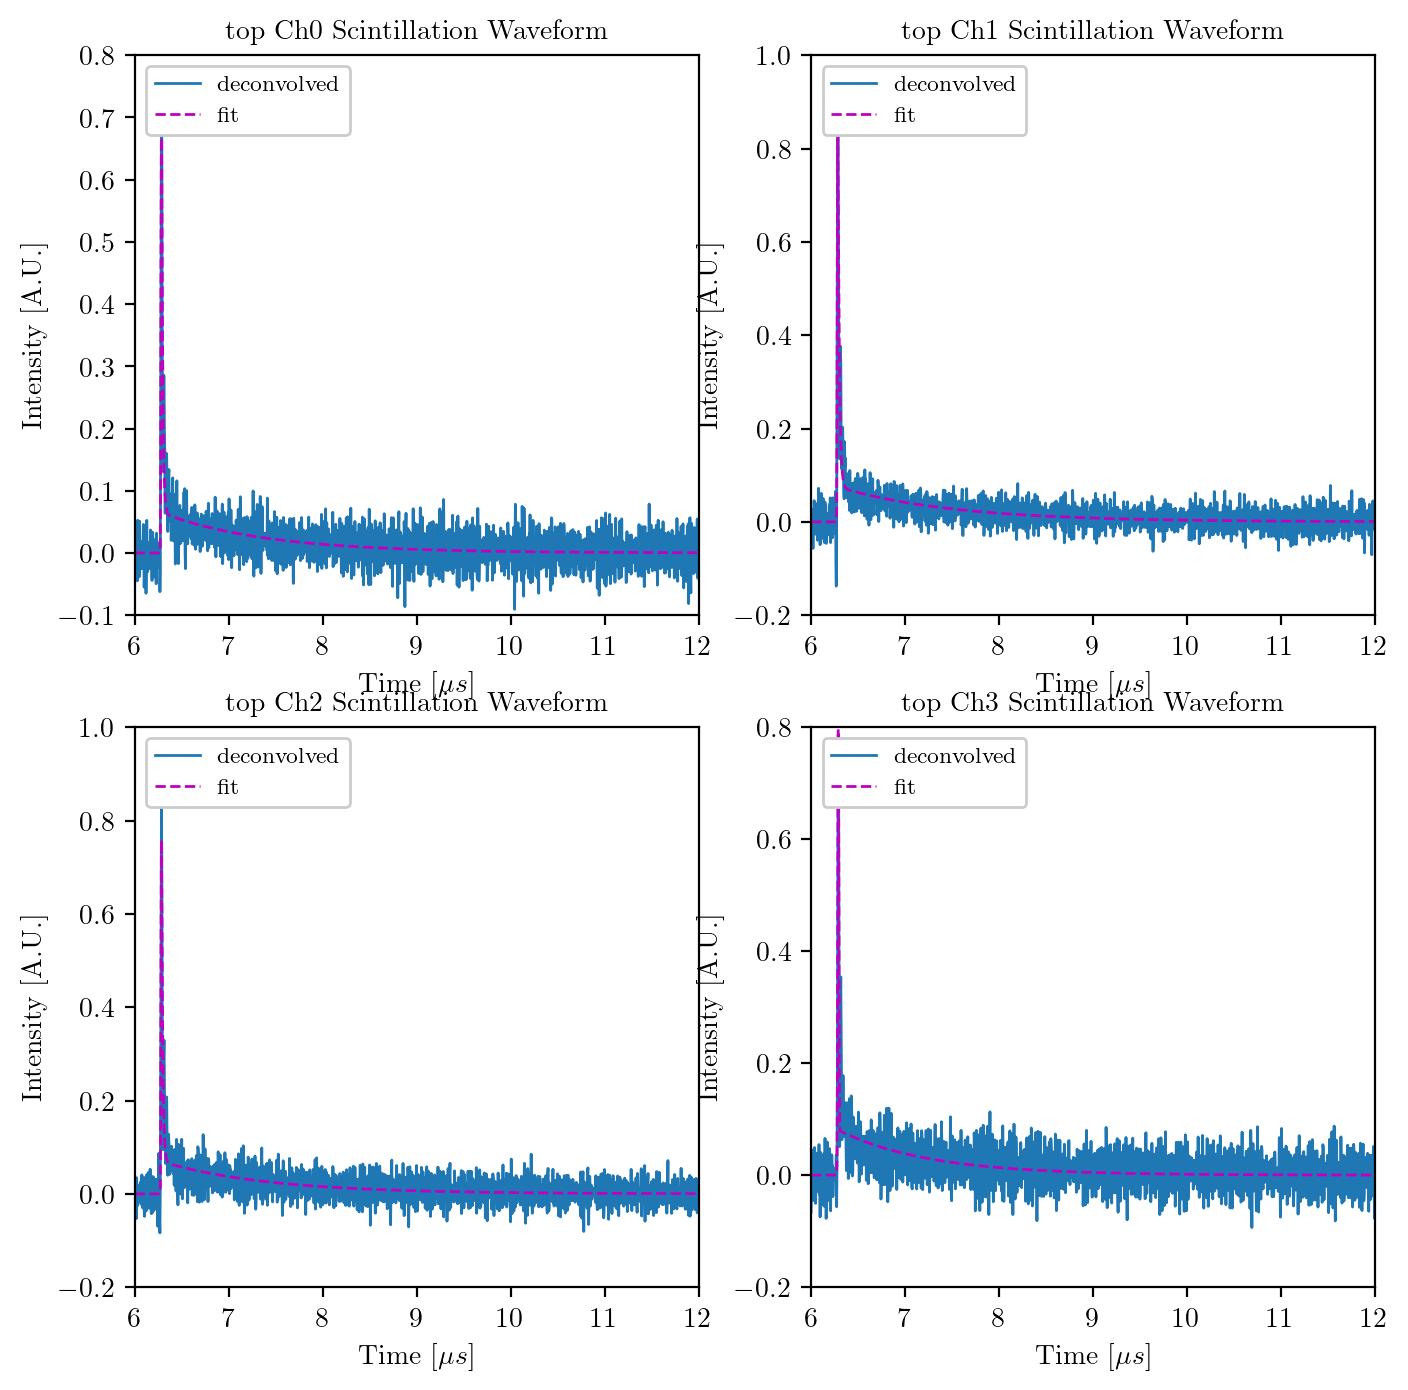

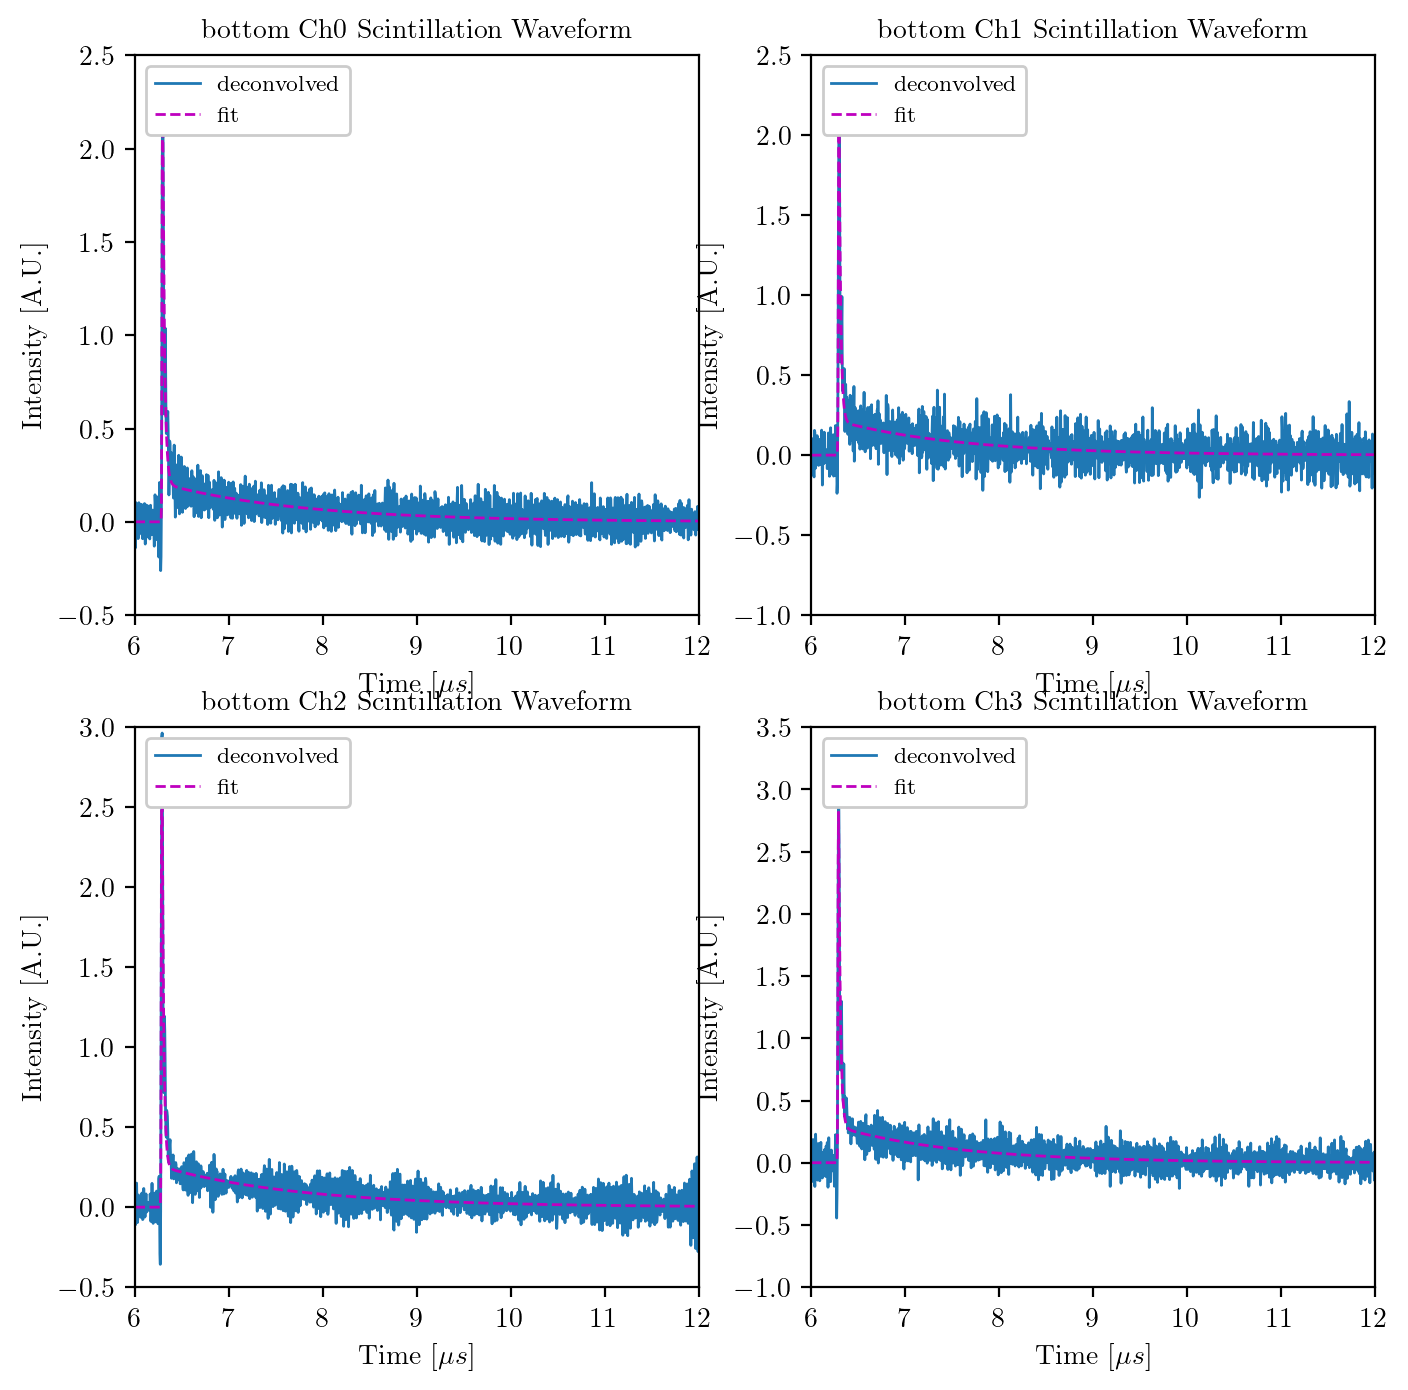

In [6]:
pos = ['top', 'bottom']
deconv1120 = []
triplet1120 = []
for i,p in enumerate(pos):
    deconv_pos = np.zeros(time.size)
    for ch in range(4):
        plt.figure(i,figsize=(8,8))
        file = ROOT.TFile('/scratch/gpfs/as111/root/gamma_1120_65V_{}.root'.format(p))
        scint_graph = file.Get('gScintWf_ch{}'.format(ch))
        file.Close()
        deconv_ch = ifft(fft(np.array(list(scint_graph.GetY())))/spe_fft[i][ch]).real
        deconv_pos += deconv_ch

        t0 = np.argmax(deconv_ch)-int(0.1/dt)
        length = int(6/dt)
        bsl = np.argmax(deconv_ch)-int(0.5/dt)
        err = np.std(deconv_ch[:bsl])

        popt,pcov = curve_fit(scintillation_pulse,time[t0:t0+length], deconv_ch[t0:t0+length], p0=[2, 0.015, 0.1, 1.3, 0.0035, 6.28], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        
        plt.subplot(2,2,ch+1)
        plt.plot(time, deconv_ch, label='deconvolved', linewidth=1)
        plt.plot(time, scintillation_pulse(time, *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(pos[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        plt.xlim(6,12)
    deconv1120.append(deconv_pos)

Now the deconvolved waveforms are summed over the channels and fitted by the functions calculated at the beginning.

ch3 A_S=4.05+/-0.14  TAU_S=0.0147+/-0.0006us  A_T=0.27+/-0.01  TAU_T=1.211+/-0.055us sigma=0.0035+/-0.0002us t0=6.276+/-0.000us
ch3 A_S=12.02+/-0.27  TAU_S=0.0212+/-0.0006us  A_T=0.93+/-0.02  TAU_T=1.437+/-0.047us sigma=0.0041+/-0.0002us t0=6.282+/-0.000us


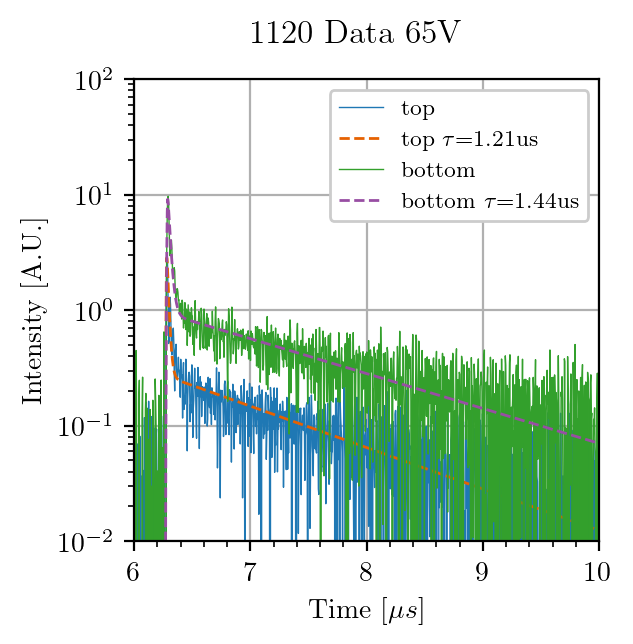

In [7]:
plt.figure(0,figsize=(3,3))
triplet1120 = []
for i,dc in enumerate(deconv1120):
    t0 = np.argmax(dc)-int(0.1/dt)
    length = int(6/dt)
    bsl = np.argmax(dc)-int(0.5/dt)
    err = np.std(dc[:bsl])

    popt,pcov = curve_fit(scintillation_pulse, time[t0:t0+length], dc[t0:t0+length], p0=[2, 0.015, 0.1, 1.3, 0.0035, 6.28], sigma=[err]*length, maxfev=100000)
    print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))

    triplet1120.append([popt[3], np.sqrt(pcov[3,3])])
    plt.plot(time, dc, '-', label=pos[i], linewidth=0.5)
    plt.plot(time[t0:t0+length], scintillation_pulse(time[t0:t0+length], *popt), '--', label=r'{} $\tau$={:.2f}us'.format(pos[i], popt[3]), linewidth=1)

plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 10)
plt.ylim(1e-2, 1e2)
plt.suptitle('1120 Data 65V')
plt.minorticks_on()
plt.grid()

# Triplet lifetime evolution

In [8]:
files_top = [] #[date label, days since getter on]
for i in range(16):
    files_top.append(['1108_{}'.format(i),2.0+(5.0+i*1.05)/24.0]) #1h 3min apart
files_top.append(['1109',2.0+4.5/24.0])
files_top.append(['1110',3.0+3.5/24.0])
files_top.append(['1114',7.0+0.5/24.0])
files_top.append(['1115',8.0+0.5/24.0])
files_top.append(['1117',10.0+0.5/24.0])
files_top.append(['1118',11.0+4.5/24.0])
files_top.append(['1120',13.0+4.5/24.0])

files_bot = []
for i in range(6):
    files_bot.append(['1107_p{}'.format(i+1),i*45.0/60.0/24.0])
for i in range(14):
    files_bot.append(['1107_{}'.format(i),(5.0+i*1.05)/24.0])
files_bot.append(['1109',2.0-0.5/24.0])
files_bot.append(['1110',3.0+5.0/24.0])
for i in range(20):
    files_bot.append(['1110_{}'.format(i),3.0+(5.5+i*4.0)/24.0])
files_bot.append(['1115',8.0+6.0/24.0])
for i in range(6):
    files_bot.append(['1115_{}'.format(i),8.0+(6.0+i*3.0)/24.0])
files_bot.append(['1116',9.0+5.5/24.0])
for i in range(6):
    files_bot.append(['1116_{}'.format(i),9.0+(6.0+i*3.0)/24.0])
files_bot.append(['1117',10.0+5.0/24.0])
files_bot.append(['1118',11.0+5.5/24.0])
for i in range(11):
    files_bot.append(['1118_{}'.format(i),11.0+(6.0+i*4)/24.0])
files_bot.append(['1120',13.0+0.5/24.0])

files = [files_top, files_bot]

In [9]:
pos = ['top', 'bottom']
triplet = []
days = []

for i,p in enumerate(pos):
    triplet_pos = []
    days_pos = []
    for j,fs in enumerate(files[i]):
        dc = np.zeros(time.size)
        file = ROOT.TFile('/scratch/gpfs/as111/root/gamma_{}_65V_{}.root'.format(fs[0],p))
        if not file.GetListOfKeys().Contains('gScintWf_ch0'):
            print('Bad file {}'.format(fs[0]))
            file.Close()
            continue

        for ch in range(4):
            scint_graph = file.Get('gScintWf_ch{}'.format(ch))
            deconv_ch = ifft(fft(np.array(list(scint_graph.GetY())))/spe_fft[i][ch]).real
            dc += deconv_ch
        file.Close()
        t0 = np.argmax(dc)-int(0.1/dt)
        length = int(6/dt)
        if(t0+length>=time.size or t0<0):
            continue
        bsl = np.argmax(dc)-int(0.5/dt)
        err = np.std(dc[:bsl])
        popt,pcov = curve_fit(scintillation_pulse, time[t0:t0+length], dc[t0:t0+length], p0=[2, 0.015, 0.1, 1.3, 0.0035, 6.28], sigma=[err]*length, maxfev=100000)
        if np.isposinf(pcov[3,3]) or np.sqrt(pcov[3,3])>0.07*popt[3]:
            continue
        print('{} {} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(p,fs[0],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        triplet_pos.append([popt[3], np.sqrt(pcov[3,3])])
        days_pos.append(fs[1])
    triplet.append(triplet_pos)
    days.append(days_pos)

top 1108_0 A_S=4.02+/-0.22  TAU_S=0.0172+/-0.0012us  A_T=0.29+/-0.01  TAU_T=0.849+/-0.055us sigma=0.0067+/-0.0004us t0=6.264+/-0.000us
top 1108_1 A_S=4.08+/-0.23  TAU_S=0.0169+/-0.0012us  A_T=0.29+/-0.01  TAU_T=0.855+/-0.056us sigma=0.0068+/-0.0004us t0=6.264+/-0.000us
top 1108_2 A_S=4.27+/-0.24  TAU_S=0.0160+/-0.0011us  A_T=0.29+/-0.01  TAU_T=0.856+/-0.050us sigma=0.0072+/-0.0004us t0=6.264+/-0.000us
top 1108_3 A_S=4.17+/-0.26  TAU_S=0.0165+/-0.0012us  A_T=0.29+/-0.02  TAU_T=0.869+/-0.058us sigma=0.0071+/-0.0005us t0=6.264+/-0.000us
top 1108_4 A_S=4.17+/-0.24  TAU_S=0.0166+/-0.0011us  A_T=0.29+/-0.01  TAU_T=0.882+/-0.054us sigma=0.0072+/-0.0004us t0=6.264+/-0.000us
top 1108_5 A_S=4.03+/-0.21  TAU_S=0.0174+/-0.0011us  A_T=0.29+/-0.01  TAU_T=0.900+/-0.054us sigma=0.0070+/-0.0004us t0=6.264+/-0.000us
top 1108_7 A_S=4.18+/-0.25  TAU_S=0.0165+/-0.0012us  A_T=0.29+/-0.01  TAU_T=0.906+/-0.058us sigma=0.0073+/-0.0005us t0=6.264+/-0.000us
top 1108_8 A_S=4.12+/-0.23  TAU_S=0.0167+/-0.0011us  A_

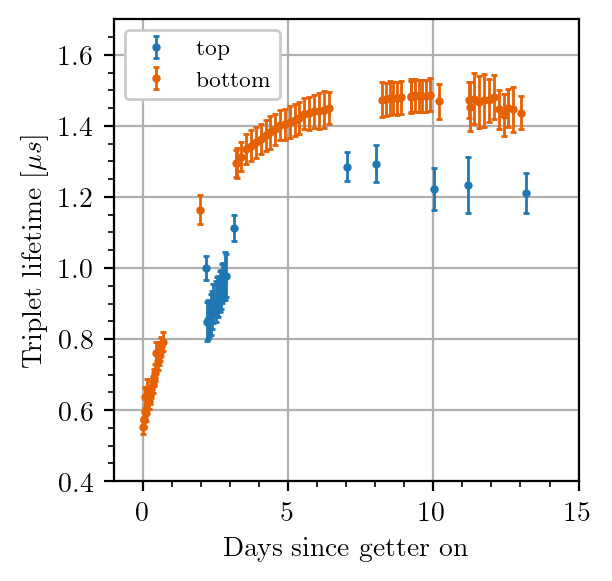

In [10]:
plt.figure(0,figsize=(3,3))
for i,p in enumerate(pos):
    plt.errorbar(days[i], np.array(triplet[i])[:,0], yerr=np.array(triplet[i])[:,1], label=p, ls='none', fmt='o', markersize=2, elinewidth=1, capsize=1)
plt.legend()
plt.xlim(-1, 15)
plt.ylim(0.4,1.7)
plt.xlabel('Days since getter on')
plt.ylabel(r'Triplet lifetime [$\mu s$]')
plt.minorticks_on()
plt.grid()